# Tyson Model Growth Curve Plot

This notebook serves as a mechanism to visualize the division dynamics of the Tyson et al. model of the cell cycle. 

In [1]:
# import required libraries
import pickle

import os
import sys

import yaml

import libsbml
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.sans-serif'] = ['Arial']

Specify the working directory and model path

In [2]:
cd = os.getcwd()
wd = os.path.dirname(cd)
sys.path.append(os.path.join(wd,'bin'))

sbml_file = "SPARCED.xml"


sbml_reader = libsbml.SBMLReader()
sbml_doc = sbml_reader.readSBML(os.path.join(wd,sbml_file))
sbml_model = sbml_doc.getModel()

species_all = [str(x.getId()) for x in list(sbml_model.getListOfSpecies())]

output_dir_main = os.path.join(wd,'output')

exp_title = 'testmpi_cc'
output_main = os.path.join(wd,'output',exp_title)


File-loading stage

In [3]:
files = os.listdir(output_main)
files.remove('output_preinc.pkl')
results = {}

for i,file in enumerate(files):
    with open(os.path.join(output_main,file),'rb') as f:
        results['output_g'+str(i+1)] = pickle.load(f)

n_gen = len(results)

The `pop_dyn` function below extracts the number of simulated cells over time

In [4]:
def pop_dyn(results, n_gen): # cell population over time
    
    n_cells = sum([len(results[x]) for x in results.keys()])
    
    tout_starts = []
    tout_ends = []
    
    tout_deaths = np.ones(n_cells)*np.nan
    cell_idx = []
    cell_count = 0

    for g in range(n_gen):
        output_gen = results['output_g'+str(g+1)]

        n_cells_g = len(output_gen)
            
        for c in range(n_cells_g):
            cell_idx.append((g+1,c+1))

            cell_data = results['output_g'+str(g+1)][str(c+1)]

            if 'output' in cell_data:
                tout = cell_data['output']['tout']


                if tout.size>1:
                    tout_starts.append(tout[0])
                    tout_ends.append(tout[-1])
                    
                elif tout.size == 1:
                    tout_starts.append(tout[0])
                    tout_ends.append(tout[0])

                cell_count +=1

            else:
                print(f"Warning: 'output' key missing in results['output_g{g+1}']['{c+1}']")
                continue
    
    timepoints_all = np.concatenate((tout_starts,tout_ends))
    
    timepoints_all = np.unique(timepoints_all)
    
    cells_all = np.zeros((n_cells,len(timepoints_all)))
    
    for c in range(n_cells):
        if c >= len(tout_starts) or c >= len(tout_ends):
            print(f"Warning: Missing start or end time for cell {c}. Skipping.")
            continue
        s_match = np.where(timepoints_all == tout_starts[c])[0]
        e_match = np.where(timepoints_all == tout_ends[c])[0]

        if s_match.size > 0 and e_match.size > 0:
            s = s_match[0]
            e = e_match[0]
            cells_all[c, s:e+1] = np.ones(e+1 - s)
        else:
            print(f"Warning: Start or end time not found for cell {c}. Skipping.")
                
    timecourse_cellpop = [sum(cells_all[:,t]) for t in range(len(timepoints_all))]
    
    return timecourse_cellpop, timepoints_all, tout_deaths        


timecourse_cellpop, timepoints_all, tout_deaths = pop_dyn(results, n_gen)

In [ ]:
def cut_time_to_size(config_path= '../sim_configs/default.json', time_array=timepoints_all, cell_count_array=timecourse_cellpop):
    """Removes extended time and simulation lengths present as a result of the asynchronously
    cycling population."""
    with open(config_path, 'rb') as f:
        config = yaml.safe_load(f)

    HOURS_TO_MINUTES = 60

    proper_timelength = (config['exp_time'] * HOURS_TO_MINUTES)

    TIMESTEP = 30 # seconds

    valid_indices = np.where(time_array <= proper_timelength)[0]

    proper_max_time_index = valid_indices[-1]
    time_array = time_array[:proper_max_time_index]

    cell_count_array = cell_count_array[:proper_max_time_index]

    return time_array, cell_count_array


Plotting Stage

360
modified time array: 57
modified cell count array: 57


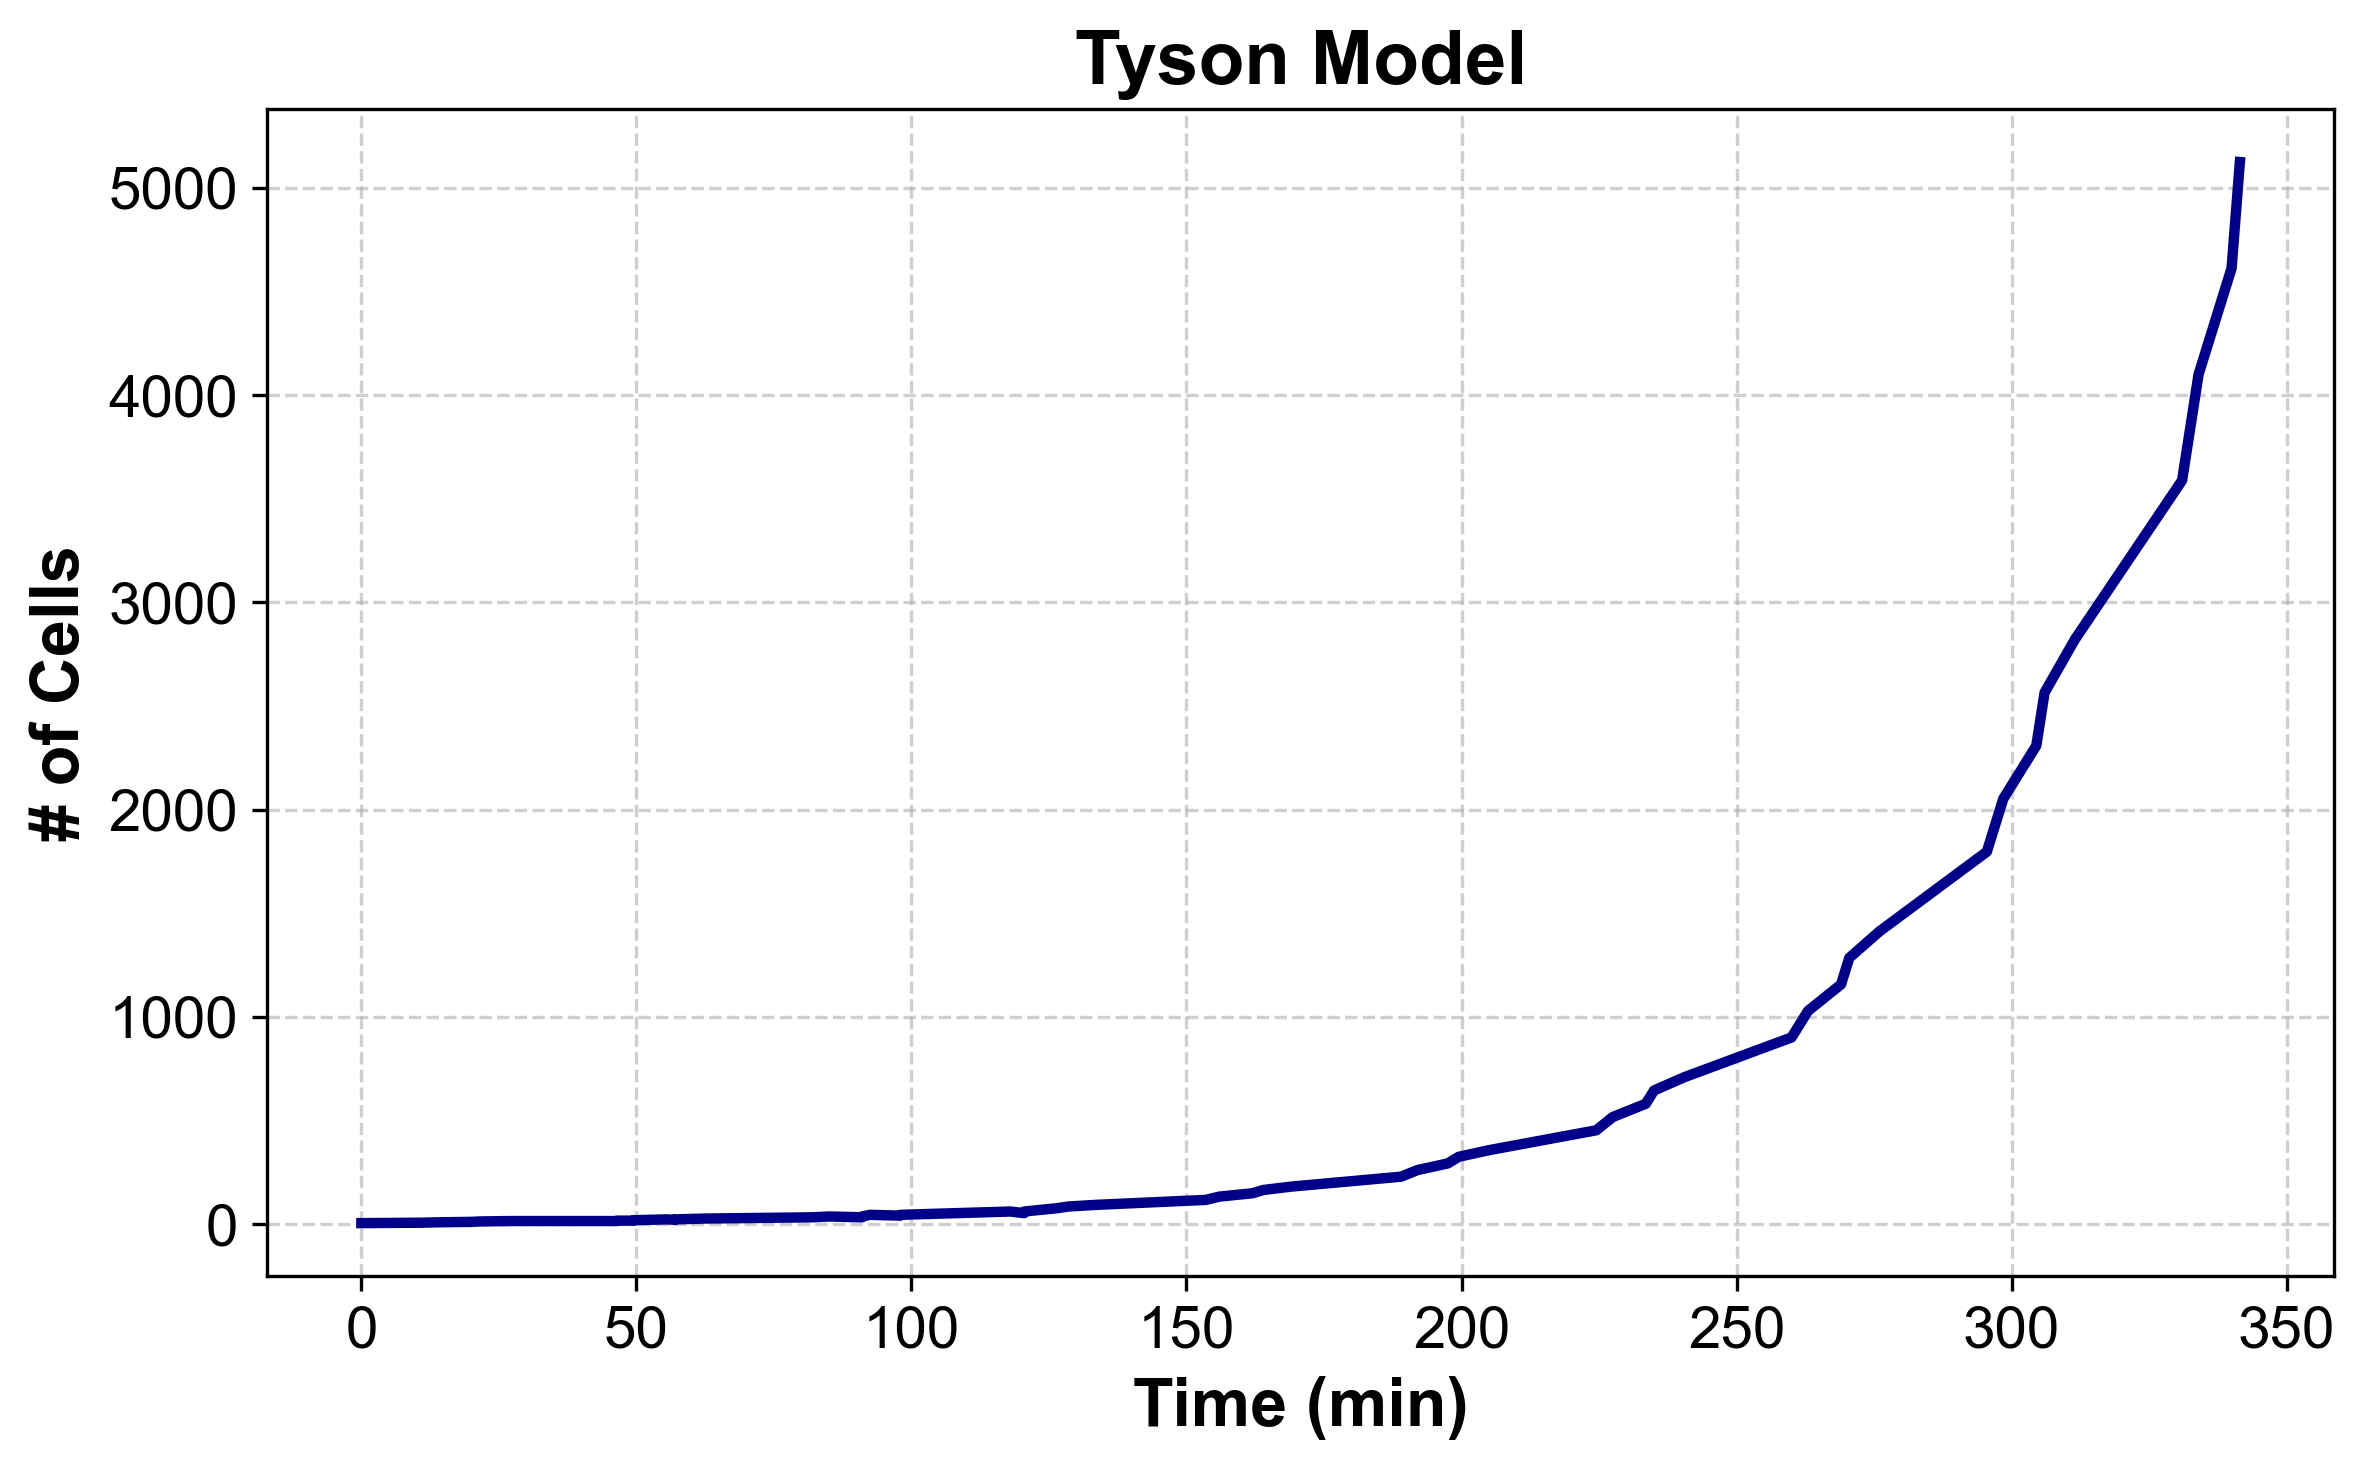

In [6]:
x_dl, y_dl = cut_time_to_size()

# Create plot
plt.figure(figsize=(8, 5))  # Set figure size
plt.plot(x_dl, y_dl, linewidth=2.5, color='darkblue', linestyle='-', markersize=5, markerfacecolor='red')

# Formatting
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time (min)', fontsize=16, fontweight='bold')
plt.ylabel('# of Cells', fontsize=16, fontweight='bold')
plt.title('Tyson Model', fontsize=18, fontweight='bold')

# Grid and style
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show plot
plt.show()
